In [1]:
from plot_utils import plot_loss, plot_histogram_balance_of_dataset, plot_confusion_matrix, plot_multiclass_roc_auc, \
    plot_metrics_table
from model import Model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from plot_utils import plot_multiclass_calibration_curve

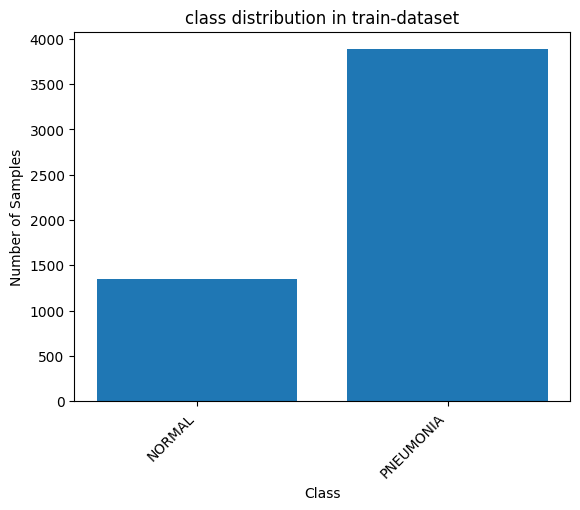

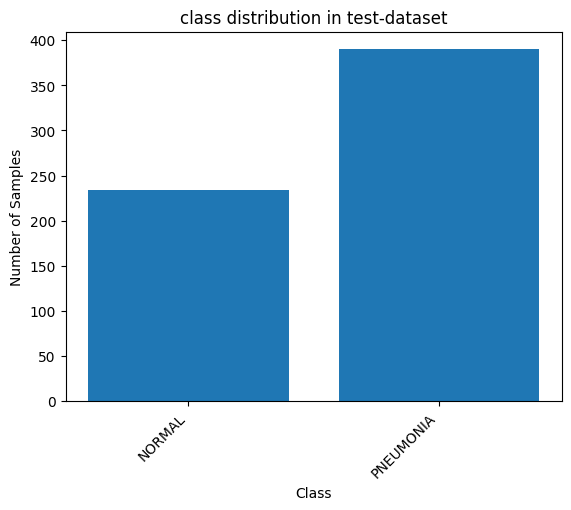

In [2]:
train_val_split_ratio = 0.8
batch_size = 32
learning_rate = 1e-7
patience_early_stopping = 15
patience_reduce_learning_rate = 4
weight_decay = 1e-4
momentum = 0.9
epochs = 100
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

model = Model(learning_rate=learning_rate, batch_size=batch_size, patience_early_stopping=patience_early_stopping,
              patience_reduce_learning_rate=patience_reduce_learning_rate, train_dir=train_dir,
              weight_decay=weight_decay, momentum=momentum, test_dir=test_dir,
              train_val_split_ratio=train_val_split_ratio)

plot_histogram_balance_of_dataset(train_dir, "class distribution in train-dataset")
plot_histogram_balance_of_dataset(test_dir, "class distribution in test-dataset")

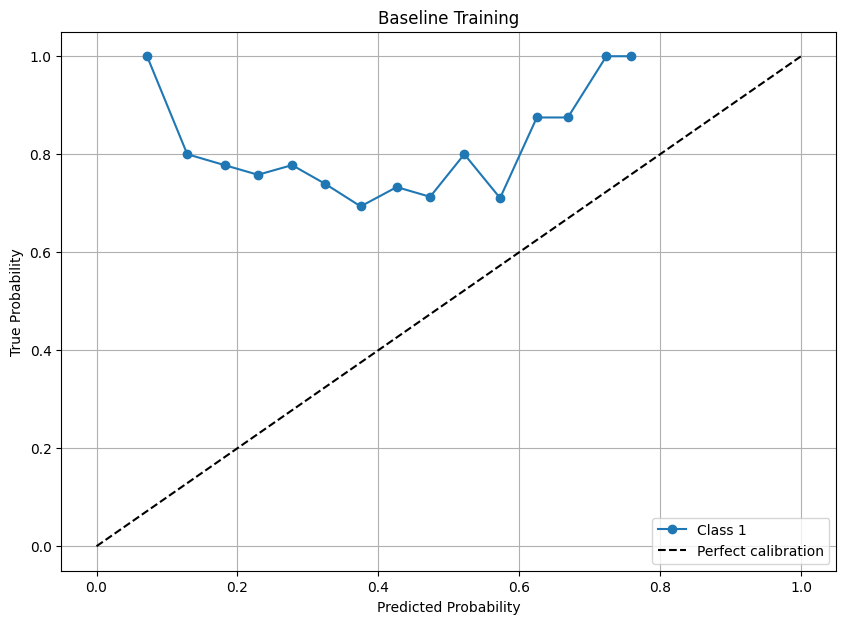

Epoch 1/100, Train Loss: 0.8323, Validation Loss: 0.8481, Learning Rate: 1e-07


In [ ]:
train_losses, val_losses = model.train_model(epochs)

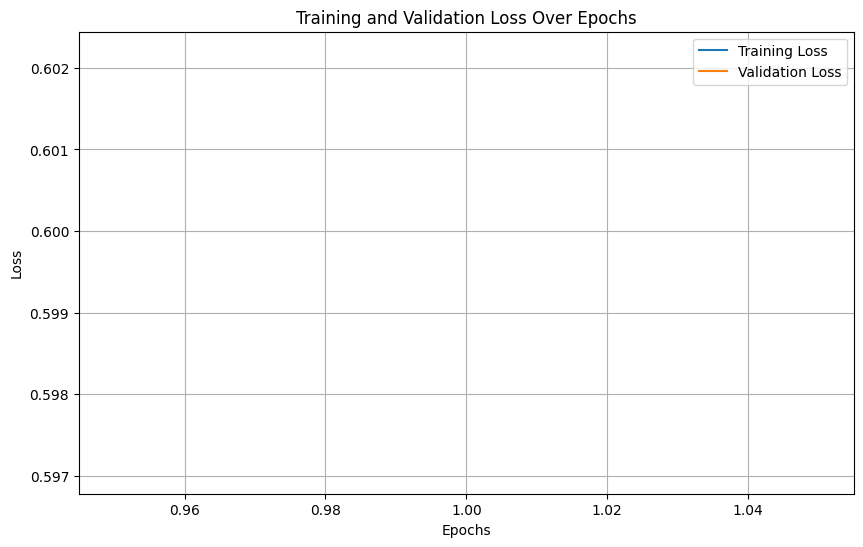

In [4]:
plot_loss(train_losses, val_losses)

In [5]:
true_labels_baseline, predicted_labels_baseline, confidence_baseline, loss_baseline = model.evaluate()

platt_scaling_model = model.optimize_platt_scaling()
true_labels_platt_scaling, predicted_labels_platt_scaling, confidence_platt_scaling, loss_platt_scaling = model.evaluate(
    calibration_model=platt_scaling_model)

temperature_model = model.optimize_temperature()
true_labels_temperature_scaling, predicted_labels_temperature_scaling, confidence_temperature_scaling, loss_temperature_scaling = model.evaluate(
    calibration_model=temperature_model)


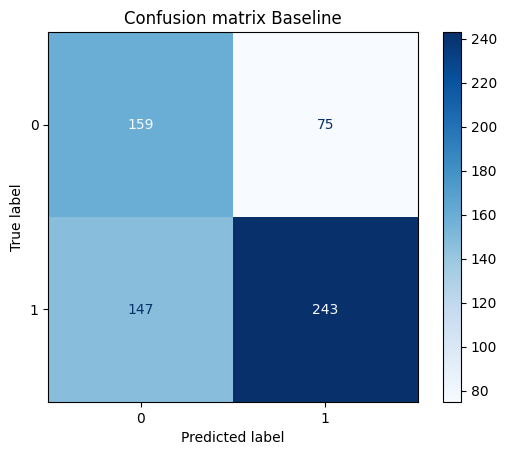

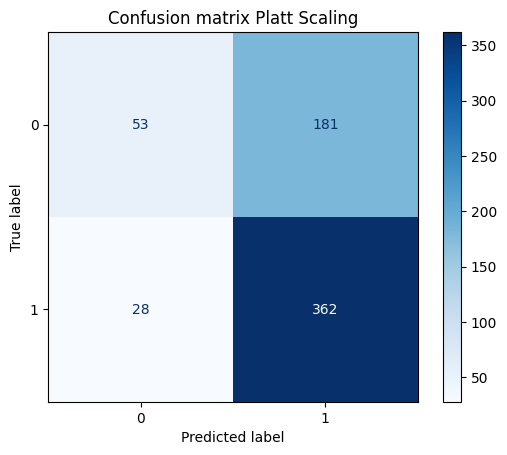

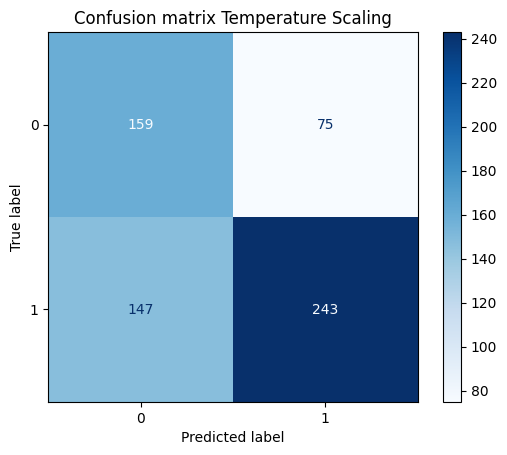

In [6]:
plot_confusion_matrix(true_labels=true_labels_baseline,
                      predicted_labels=predicted_labels_baseline,
                      title="Confusion matrix Baseline")

plot_confusion_matrix(true_labels=true_labels_platt_scaling,
                      predicted_labels=predicted_labels_platt_scaling,
                      title="Confusion matrix Platt Scaling")

plot_confusion_matrix(true_labels=true_labels_temperature_scaling,
                      predicted_labels=predicted_labels_temperature_scaling,
                      title="Confusion matrix Temperature Scaling")

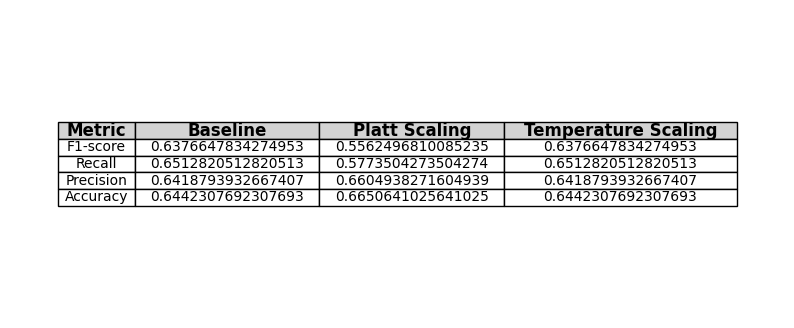

In [7]:
results = {
    "Metric": ["F1-score", "Recall", "Precision", "Accuracy"],
    "Baseline": [
        f1_score(true_labels_baseline, predicted_labels_baseline, average='macro', zero_division=0),
        recall_score(true_labels_baseline, predicted_labels_baseline, average='macro', zero_division=0),
        precision_score(true_labels_baseline, predicted_labels_baseline, average='macro', zero_division=0),
        accuracy_score(true_labels_baseline, predicted_labels_baseline),
    ],
    "Platt Scaling": [
        f1_score(true_labels_platt_scaling, predicted_labels_platt_scaling, average='macro', zero_division=0),
        recall_score(true_labels_platt_scaling, predicted_labels_platt_scaling, average='macro', zero_division=0),
        precision_score(true_labels_platt_scaling, predicted_labels_platt_scaling, average='macro', zero_division=0),
        accuracy_score(true_labels_platt_scaling, predicted_labels_platt_scaling),
    ],
    "Temperature Scaling": [
        f1_score(true_labels_temperature_scaling, predicted_labels_temperature_scaling, average='macro',
                 zero_division=0),
        recall_score(true_labels_temperature_scaling, predicted_labels_temperature_scaling, average='macro',
                     zero_division=0),
        precision_score(true_labels_temperature_scaling, predicted_labels_temperature_scaling, average='macro',
                        zero_division=0),
        accuracy_score(true_labels_temperature_scaling, predicted_labels_temperature_scaling),
    ],
}

plot_metrics_table(results)

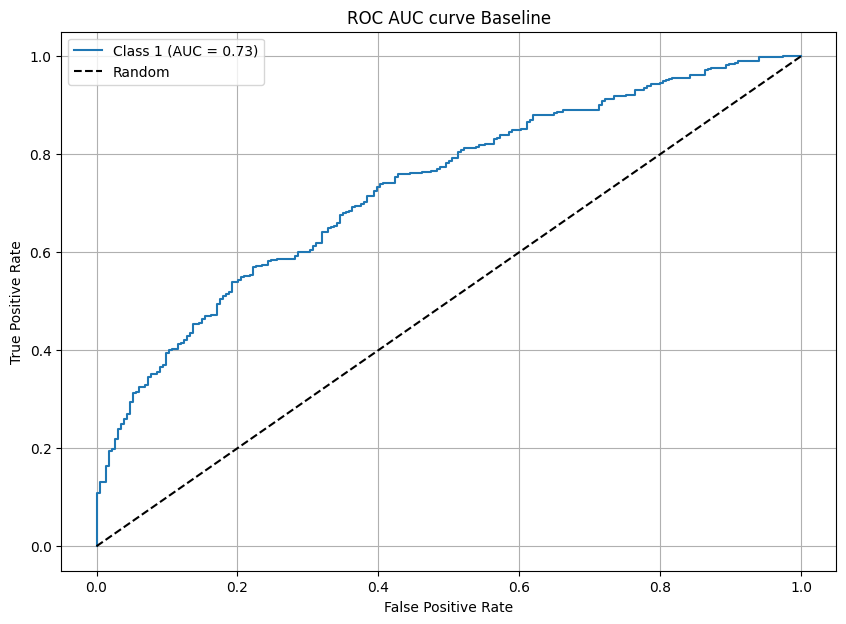

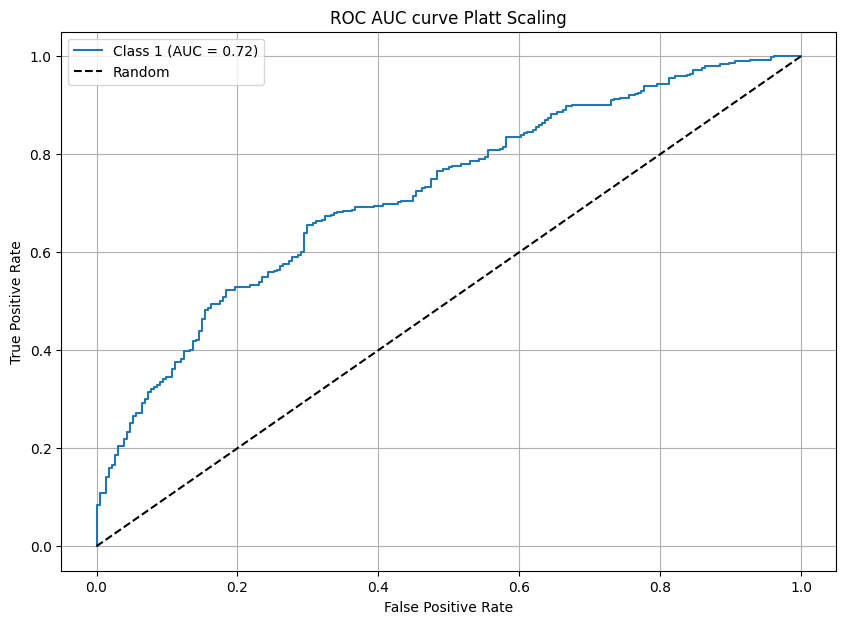

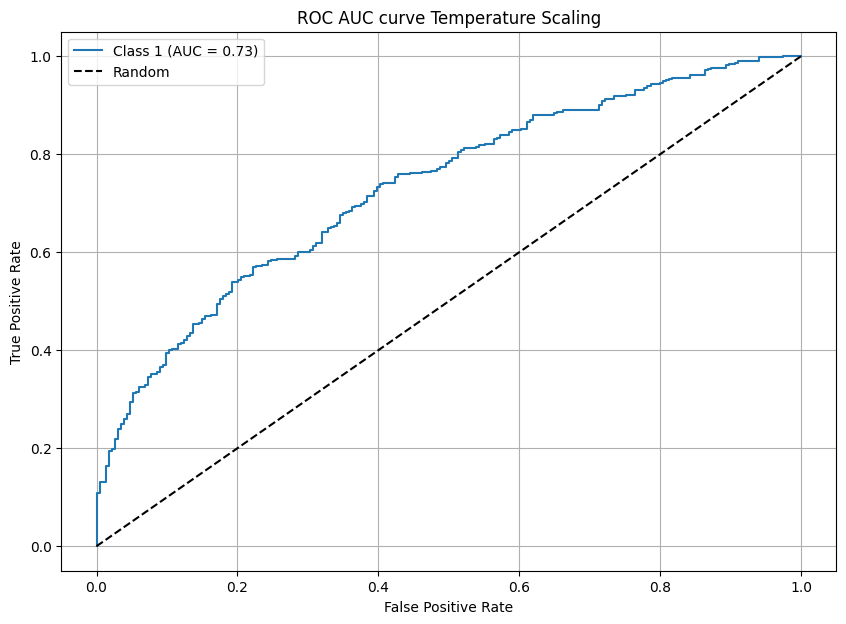

In [8]:
plot_multiclass_roc_auc(y_true=true_labels_baseline,
                        y_pred_proba=confidence_baseline,
                        title="ROC AUC curve Baseline")

plot_multiclass_roc_auc(y_true=true_labels_platt_scaling,
                        y_pred_proba=confidence_platt_scaling,
                        title="ROC AUC curve Platt Scaling")

plot_multiclass_roc_auc(y_true=true_labels_temperature_scaling,
                        y_pred_proba=confidence_temperature_scaling,
                        title="ROC AUC curve Temperature Scaling")

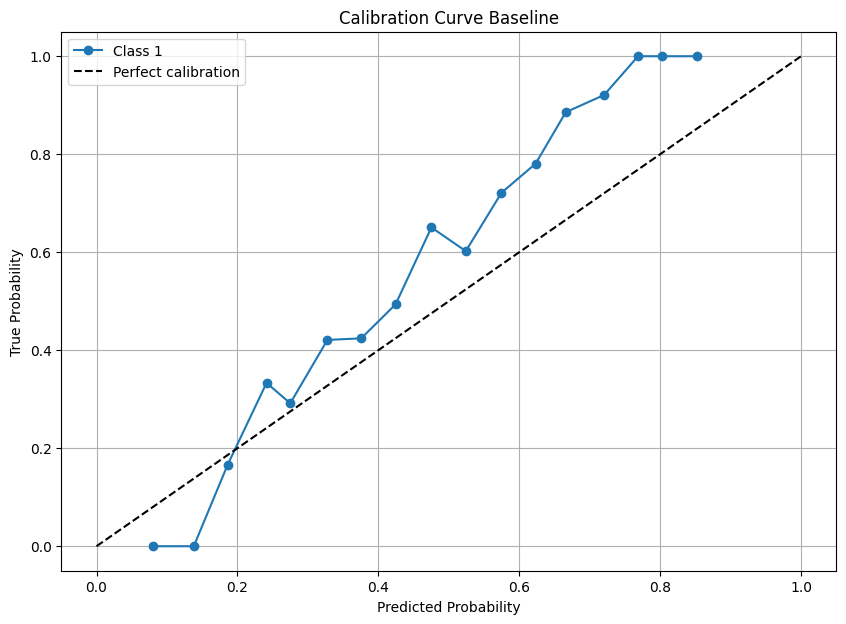

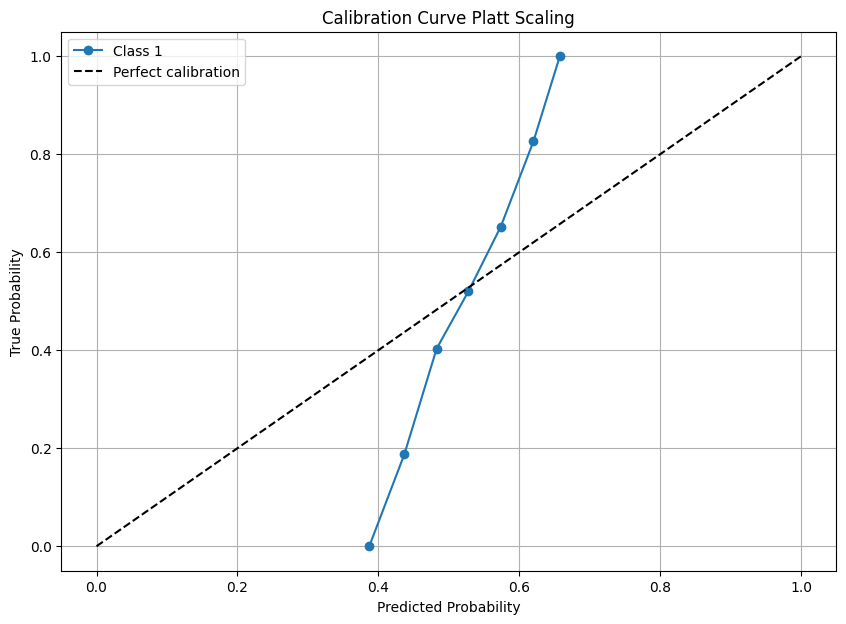

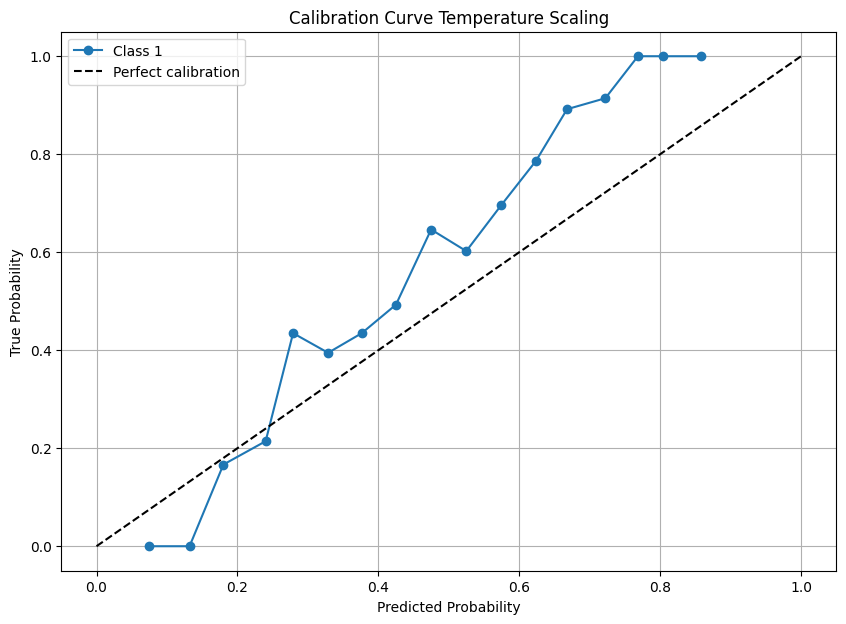

In [9]:
plot_multiclass_calibration_curve(true_labels_baseline, confidence_baseline,
                                  title="Calibration Curve Baseline")

plot_multiclass_calibration_curve(true_labels_platt_scaling, confidence_platt_scaling,
                                  title="Calibration Curve Platt Scaling")

plot_multiclass_calibration_curve(true_labels_temperature_scaling, confidence_temperature_scaling,
                                  title="Calibration Curve Temperature Scaling")

In [10]:
import torch

torch.save(model.model.state_dict(), "model.pth")